# *Causal Tests with Linear Regression on Yeast Data*
## NORBIS Course -- Genomics for Precision Medicine
### This Notebook uses Python 3
>### *Adriaan Ludl @ University of Bergen, Norway*
>###  2021.06.18
> 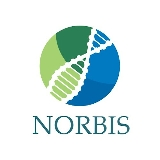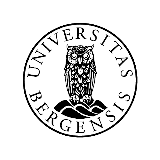



# Tasks:

## 1. Retrieve and make a *graphical representation* of **gene expression values**.

## 2. Perform *linear regression* on **gene pairs** and visualise the result.

## 3. Answer the following question:
>### Are the **distributions** of the Regulator and Target Genes' expression values **different** for the possible Marker (eQTL) genotypes ?

In [1]:
# Packages for computations:
import numpy as np
import pandas as pan

#from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

In [2]:
# Packages for making figures:
from IPython.core.display import display
import matplotlib.pylab as plt
#%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns
#sns.set_style( 'dark' )

sns.set(style="ticks", context="talk", font_scale=0.5,
        rc={'figure.figsize':(8,4),'figure.dpi':100})


In [ ]:
# A package to plot RainCloud diagrams:
!pip install ptitprince
import ptitprince as pt

In [ ]:
#!pip install gdown

# Load yeast gene expression data from:
>##   1: Albert et al. (2018) eLife:
>##     Genetics of trans-regulatory variation in gene expression
>###     https://elifesciences.org/articles/35471    
>##     Supplementary Information at:
>###     https://figshare.com/s/83bddc1ddf3f97108ad4

In [ ]:
# 1. download : map_cluster_index_to_short_gene_name.csv
!gdown https://drive.google.com/uc?id=1rkCTQRG2fVtnyKHnEw3GWyYi4FZzLuAi
#!head  map_cluster_index_to_short_gene_name.csv

Downloading...
From: https://drive.google.com/uc?id=1rkCTQRG2fVtnyKHnEw3GWyYi4FZzLuAi
To: /content/map_cluster_index_to_short_gene_name.csv
100% 107k/107k [00:00<00:00, 3.30MB/s]


In [ ]:
# 2. download : strongest_eqtls_r_3columns.csv
!gdown https://drive.google.com/uc?id=1TahDWA9wubbhX6ejBTNggmPQq8d28d85
#!head  strongest_eqtls_r_3columns.csv

Downloading...
From: https://drive.google.com/uc?id=1TahDWA9wubbhX6ejBTNggmPQq8d28d85
To: /content/strongest_eqtls_r_3columns.csv
100% 146k/146k [00:00<00:00, 9.37MB/s]


In [ ]:
# 3. download : genotypes_binary_strongest_eqtl.csv
!gdown https://drive.google.com/uc?id=1wl8C8b45ZUK0MlgI8xBkCpowAyOWtKtX
#!head  genotypes_binary_strongest_eqtl.csv

Downloading...
From: https://drive.google.com/uc?id=1wl8C8b45ZUK0MlgI8xBkCpowAyOWtKtX
To: /content/genotypes_binary_strongest_eqtl.csv
5.90MB [00:00, 35.9MB/s]


In [ ]:
# 4. download : expression_statsmodels_linreg_residuals_01.csv.gz
!gdown https://drive.google.com/uc?id=1-dxyvDONQ9KDJC2ejzyCHiOQ-bRmHu12
#!head  expression_statsmodels_linreg_residuals_01.csv.gz

Downloading...
From: https://drive.google.com/uc?id=1-dxyvDONQ9KDJC2ejzyCHiOQ-bRmHu12
To: /content/expression_statsmodels_linreg_residuals_01.csv.gz
51.2MB [00:00, 62.7MB/s]


In [ ]:
# list the files loaded:
! ls -alh

total 55M
drwxr-xr-x 1 root root 4.0K Jun 18 09:28 .
drwxr-xr-x 1 root root 4.0K Jun 18 07:19 ..
drwxr-xr-x 4 root root 4.0K Jun 15 13:37 .config
-rw-r--r-- 1 root root  49M Jun 18 09:28 expression_statsmodels_linreg_residuals_01.csv.gz
-rw-r--r-- 1 root root 5.7M Jun 18 09:28 genotypes_binary_strongest_eqtl.csv
-rw-r--r-- 1 root root 105K Jun 18 09:28 map_cluster_index_to_short_gene_name.csv
drwxr-xr-x 1 root root 4.0K Jun 15 13:37 sample_data
-rw-r--r-- 1 root root 143K Jun 18 09:28 strongest_eqtls_r_3columns.csv


In [ ]:
# load table of TF and gene names
tf_path = './'
tf_file = 'map_cluster_index_to_short_gene_name.csv'
names = pan.read_csv( tf_path + tf_file, header=None,
                            #usecols=[0,1,7,10],
                            names='ordinal long_name name'.split(),
                    )

In [ ]:
# Translate gene names ...
a_name = 'DNM1'
a_ordinal = names.loc[ names.name == a_name ].ordinal.values[0]
a_gene = names.loc[ names.name == a_name ]
a_long_name = a_gene['long_name'].values[0]

b_name = 'STB5'
b_ordinal = names.loc[ names.name == b_name ].ordinal.values[0]
b_gene = names.loc[ names.name == b_name ]
b_long_name = b_gene['long_name'].values[0]

print(a_name, a_long_name, a_ordinal)
print( b_name, b_long_name, b_ordinal)
print(a_gene)
print(b_gene)

DNM1 YLL001W 1746
STB5 YHR178W 1230
      ordinal long_name  name
1746     1746   YLL001W  DNM1
      ordinal long_name  name
1230     1230   YHR178W  STB5


In [ ]:
print('# 1.  Load yeast data:')
# ncols and nrows for downscaled version ...

n_eqtls=None
n_genes=None
n_segregants=None

#
print('# 1.a  load genes-eqtls table.')
gene_eqtl_table = pan.read_csv('./strongest_eqtls_r_3columns.csv',
                              #header=0,
                               nrows=n_genes,
                                delimiter=',')
print(gene_eqtl_table.columns)
print(gene_eqtl_table.shape)
#print(gene_eqtl_table)
n_eqtls = gene_eqtl_table.shape[0]

# 1.  Load yeast data:
# 1.a  load genes-eqtls table.
Index(['r_abs', 'gene', 'pmarker', 'r'], dtype='object')
(2884, 4)


In [ ]:
print('# 1.b  load genotypes-experiments table.')
genotypes = pan.read_csv(
    "./genotypes_binary_strongest_eqtl.csv",
                                #usecols = range(1,n_eqtls+1),
                                nrows = n_segregants,
                                delimiter=',')
                                #header=0, delimiter='\t')
genotypes = genotypes.drop(genotypes.columns[0], axis=1)
print(genotypes.columns)
print(genotypes.shape)
#print(genotypes)

# 1.b  load genotypes-experiments table.
Index(['chrI:107538_G/A', 'chrI:114628_G/T', 'chrI:114628_G/T.1',
       'chrI:131539_C/T', 'chrI:131539_C/T.1', 'chrI:132723_G/A',
       'chrI:133174_G/A', 'chrI:134219_C/T', 'chrI:136961_T/C',
       'chrI:139311_T/C',
       ...
       'chrXVI:876785_G/A.1', 'chrXVI:881962_G/A', 'chrXVI:885979_T/A',
       'chrXVI:897736_G/A', 'chrXVI:907815_T/C', 'chrXVI:921485_T/C',
       'chrXVI:922297_T/C', 'chrXVI:922883_C/CCTA', 'chrXVI:98320_T/C',
       'chrXVI:98933_T/C'],
      dtype='object', length=2884)
(1012, 2884)


In [ ]:
# use the expression data used by findr:
print('# 1.c load gene expression table.')
yeast_exp = pan.read_table(
    #"../../prepare_expression_data/linear_regression_expr/expression_linreg_residuals_01.csv",
      #"./expression_statsmodels_linreg_residuals_01.csv",
      "./expression_statsmodels_linreg_residuals_01.csv.gz",
                                #usecols = range(1,n_eqtls+1),
                                nrows = n_segregants,
                                delimiter=',')
yeast_exp = yeast_exp.drop(yeast_exp.columns[0:1], axis=1)
print(yeast_exp.columns)
print(yeast_exp.shape)

# 1.c load gene expression table.
Index(['YAL027W', 'YAL019W', 'YAL022C', 'YAL011W', 'YAL013W', 'YAL009W',
       'YAL003W', 'YAL010C', 'YAL008W', 'YAL012W',
       ...
       'YDR300C', 'YBR294W', 'YKL138C', 'YDR507C', 'YNL113W', 'YKL035W',
       'YER036C', 'YLR385C', 'YDR105C', 'YML063W'],
      dtype='object', length=5720)
(1012, 5720)


In [ ]:
# look at the values in yeast_exp
yeast_exp

,YAL027W,YAL019W,YAL022C,YAL011W,YAL013W,YAL009W,YAL003W,YAL010C,YAL008W,YAL012W,YAR002C-A,YAR002W,YAR008W,YAR003W,YAR010C,YAR009C,YAR015W,YAR018C,YAR019C,YAR020C,YAR023C,YAR029W,YAR035W,YAR042W,YAR050W,YAL062W,YAL060W,YAL056W,YAL055W,YAL054C,YAL049C,YAL047C,YAL042W,YAL038W,YAL044C,YAL039C,YAL040C,YAL033W,YAL032C,YAL029C,...,YKR043C,YGR253C,YJR036C,YDL246C,YLR002C,YAL002W,YEL077C,YPR002W,YBR257W,YDL083C,YNL247W,YPR115W,YPR130C,YDR483W,YPR131C,YBR267W,YIL135C,YNL062C,YBR108W,YPL250W-A,YDR412W,YOR280C,YDR030C,YLR138W,YIL138C,YNR039C,YPL275W,YAL016W,YNL186W,YNR026C,YDR300C,YBR294W,YKL138C,YDR507C,YNL113W,YKL035W,YER036C,YLR385C,YDR105C,YML063W
0,0.138262,0.258175,0.001430,0.148049,0.287232,0.179668,-0.016367,0.082956,-0.210394,0.018585,0.096338,0.223157,0.214197,0.141940,0.380153,2.770505,-0.142127,-0.097951,0.038334,1.313384,-1.082409,1.315915,0.000454,0.094357,0.730042,0.330394,-0.085119,-0.649130,-0.646173,-0.346952,0.168244,0.149645,0.121303,-0.210506,0.250593,-0.302342,-0.375218,0.305548,-0.259497,-0.040088,...,0.033083,-0.128328,0.098522,0.450324,0.111885,0.017938,-2.921322,-0.393976,0.047005,0.121217,0.121815,-0.240745,0.229105,-0.108794,0.172508,0.344641,0.126252,0.220883,-0.204388,0.446371,0.078014,-0.015267,-0.069245,-0.299809,-0.267748,-0.236542,-0.273889,-0.169276,0.085578,-0.055983,0.231474,1.107034,0.175225,0.243157,-0.009801,-0.186668,0.046504,1.454317,0.100412,0.048019
1,0.302246,-0.048028,0.010125,-0.247269,0.096981,0.011632,-0.026555,0.298902,0.159869,-0.338655,0.019484,-0.080909,0.186656,0.040130,1.001961,-4.206787,0.386459,0.150333,-0.131501,-1.517476,0.510312,-1.158599,-0.266858,-0.149407,0.820498,0.767773,-0.025097,0.517814,0.330344,0.465105,-0.679750,-0.010539,0.122247,-0.118951,0.115027,0.487464,0.017512,0.753389,-0.231898,-0.332433,...,0.121572,0.250312,0.026093,0.641072,0.095435,-0.283074,-0.271005,1.051615,0.135992,0.026655,0.017441,0.159047,-0.495856,-0.188968,0.358947,-0.008487,0.016793,0.086013,-0.198401,1.008152,0.022480,0.179666,0.228399,-0.118796,0.301173,0.071836,1.032451,0.064151,0.027373,-0.003683,0.031778,-0.034252,-0.045773,-0.220354,0.195735,0.216264,-0.231072,0.205060,0.097649,0.123082
2,0.087758,-0.272769,-0.161990,-0.298121,0.091253,-0.092332,0.178959,0.133216,0.152627,-0.164179,-0.148774,0.064655,0.320589,0.055724,-3.722446,-4.167111,0.138611,0.013045,-0.002351,-1.682784,0.069868,-1.767932,-0.345408,0.015559,-0.328947,0.108363,0.094490,-0.087737,0.243012,-0.190748,0.420658,-0.004176,-0.228156,-0.153383,-0.279565,0.130109,0.269294,0.125781,0.312128,-0.134233,...,-0.015475,-0.014615,0.108654,0.893816,0.033605,-0.336075,-2.289387,0.257845,0.188971,0.151161,-0.172952,0.069532,-2.049132,0.056940,0.118511,-0.065083,0.035763,0.077888,-0.213770,0.218045,0.022265,0.127094,0.126510,-0.043176,0.115116,0.123210,-0.124087,0.149833,0.152966,-0.153464,0.084201,0.267517,-0.018337,-0.159674,0.087333,0.321737,-0.129681,0.018928,0.058534,0.029780
3,-0.090353,0.079081,0.121329,0.107635,-0.007382,0.103916,-0.027771,0.179251,0.325962,-0.056383,0.177041,-0.050010,-0.241954,0.002996,0.475281,2.811903,-0.289864,-0.198914,0.072969,0.846843,0.149789,2.219137,0.101795,0.032387,0.302340,-0.579990,0.649955,-0.326423,-0.001326,0.166161,0.782070,0.015683,-0.013644,0.311105,-0.334848,-0.316416,0.305704,-1.110736,0.180303,0.260700,...,-0.192191,0.070077,0.246031,0.556513,-0.344851,0.252723,-1.950179,-0.090654,-0.209860,-0.275979,0.113978,0.136752,-0.364468,0.298516,-0.243440,-0.375265,0.151068,-0.055159,0.513131,-0.238275,-0.419652,-0.156690,-0.053543,0.120441,-0.388852,0.067785,-0.752134,0.057003,-0.162588,-0.116312,0.022918,-0.266334,-0.386191,0.278132,-0.301831,0.761324,0.092919,0.490783,0.074101,-0.259168
4,0.456007,0.070731,0.403047,0.038507,0.390859,0.241602,0.157700,0.126078,-0.022655,0.568604,0.065212,0.155635,-0.293703,0.195653,0.986341,-2.199294,-0.434326,-0.015622,0.500481,2.243009,0.639052,1.132471,0.581979,0.429787,1.175522,0.854336,-0.241392,0.658240,-0.068046,0.760988,-0.668034,-0.146575,-0.015321,0.194611

In [ ]:
# look at the values in yeast_exp
yeast_exp[yeast_exp.columns[:4]].describe()

,YAL027W,YAL019W,YAL022C,YAL011W
count,1.012000e+03,1.012000e+03,1.012000e+03,1.012000e+03
mean,-3.689613e-15,8.511445e-15,1.797441e-15,2.686284e-15
std,3.580824e-01,2.496905e-01,1.642987e-01,1.973999e-01
min,-1.206978e+00,-1.136017e+00,-6.081984e-01,-6.571120e-01
25%,-2.226971e-01,-1.614682e-01,-1.037698e-01,-1.236386e-01
50%,1.330693e-02,1.110802e-02,2.105394e-03,2.047940e-05
75%,2.526644e-01,1.660830e-01,1.057531e-01,1.326272e-01
max,1.040793e+00,1.131348e+00,7.529967e-01,8.324667e-01


# Tasks

## 1. Visual representation of gene expression values.

1.a:  Make a scatter plot of expression values for two genes of your choice.

1.b:  Make a scatter plot of expression values for the genes DNM1 and YDR477W

1.c:  Make a scatter plot of expression values for the genes STB5 and YHR163W

Note: **you have to *select* the genes that you want to study**.

For 1.a you can choose any two different genes.

For 1.b and 1.c we suggest the genes to look at,

you will have to *translate* the **short names** to **long names**.

-------------------------------------------

This can be done either using the data from 
>"map_cluster_index_to_short_gene_name.csv"

 stored in the variable ***names*** as in the example above,

or by searching in **online resources** such as the SGD or ensembl.

In [ ]:
# Write code here to translate gene names:


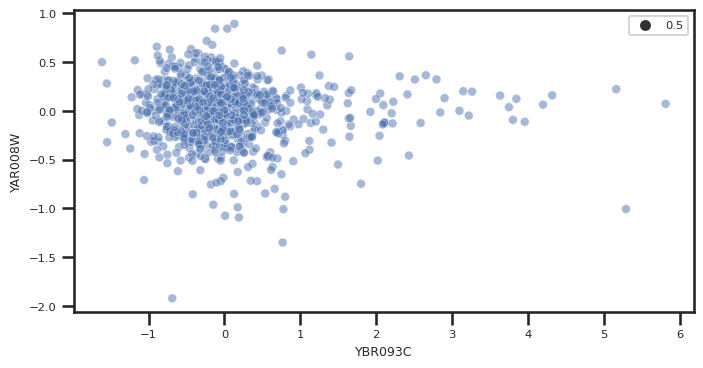

In [ ]:
# 1.a Make a scatter plot of expression values for two genes of your choice.
gene_1=yeast_exp.columns[ 0 ] # <- write the a number between 0 and 1011 between the [ ]
gene_2=yeast_exp.columns[ 0 ] # <- write the a number between 0 and 1011 between the [ ]
sns.scatterplot(x=yeast_exp[gene_1],y=yeast_exp[gene_2],
                size=0.5, alpha=0.5, palette="colorblind")

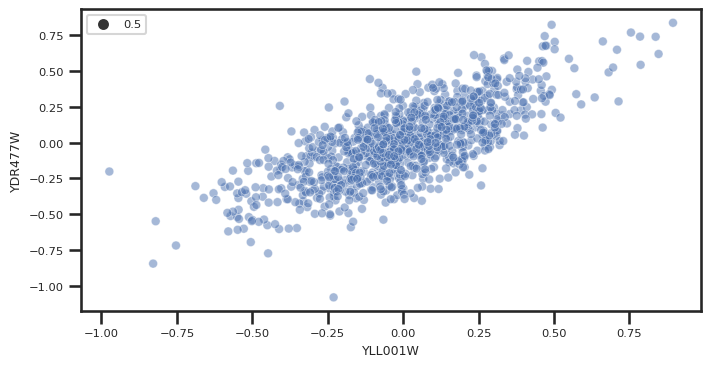

In [ ]:
# 1.b Make a scatter plot of expression values for the genes DNM1 and YDR477W
gene_1='' # '' : <- write the name of a yeast gene between the quotes
gene_2='' # '' : <- write the name of a yeast gene between the quotes
sns.scatterplot(x=yeast_exp[gene_1],y=yeast_exp[gene_2],
                size=0.5, alpha=0.5, palette="Set1")
#                size=0.5, alpha=0.5, palette=sns.color_palette("husl", 8)
#)

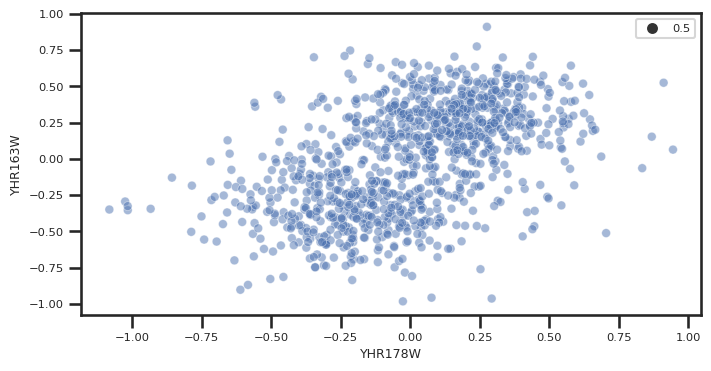

In [ ]:
# 1.c Make a scatter plot of expression values for the genes STB5 and YHR163W
gene_1='' # '' : <- write the name of a yeast gene between the quotes
gene_2='' # '' : <- write the name of a yeast gene between the quotes
sns.scatterplot(x=yeast_exp[gene_1],y=yeast_exp[gene_2],
                size=0.5, alpha=0.5, palette="Set2")

##  2. Perform linear regression on gene pairs

## 2.a For DNM1 and YDR477W

### *Note*: We will use the statsmodels package is used to perform linear regression:

In [ ]:
# We will use the statsmodels package is used to perform linear regression:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### TODO: define the dataframe that contains the data on which we will perform regression
Write in the cell below:

In [ ]:
# TODO: define the dataframe that contains the data on which we will perform regression

gene_1='' # <- write the name of a yeast gene between the quotes
gene_2='' # <- write the name of a yeast gene between the quotes

data_for_regression = pan.DataFrame()

data_for_regression[gene_1] = yeast_exp[ gene_1 ]
data_for_regression[gene_2] = yeast_exp[ gene_2 ]

In [ ]:
mod = smf.ols(formula=gene_2+' ~ '+gene_1, data=data_for_regression)

regression_result = mod.fit()

print(regression_result.summary())

                            OLS Regression Results                            
Dep. Variable:                YDR477W   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     1223.
Date:                Thu, 17 Jun 2021   Prob (F-statistic):          3.49e-176
Time:                        22:40:19   Log-Likelihood:                 322.85
No. Observations:                1012   AIC:                            -641.7
Df Residuals:                    1010   BIC:                            -631.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.02e-15      0.006  -1.84e-13      1.0

### Make Figures that show the result of the Linear Regression (or fit):

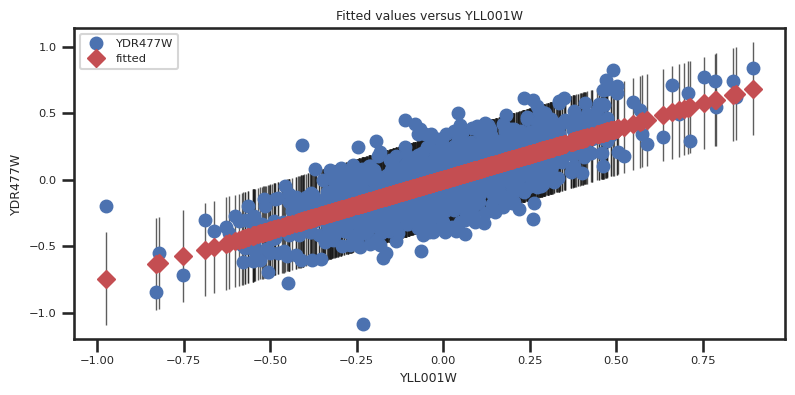

In [ ]:
# Plot of the model fit
#  note: vertical bars show confidence intervals for the predicted values (red)
#        data points are shown in blue
fig = sm.graphics.plot_fit(regression_result, gene_1)
fig.tight_layout(pad=1.0)

Text(0, 0.5, 'Residuals')

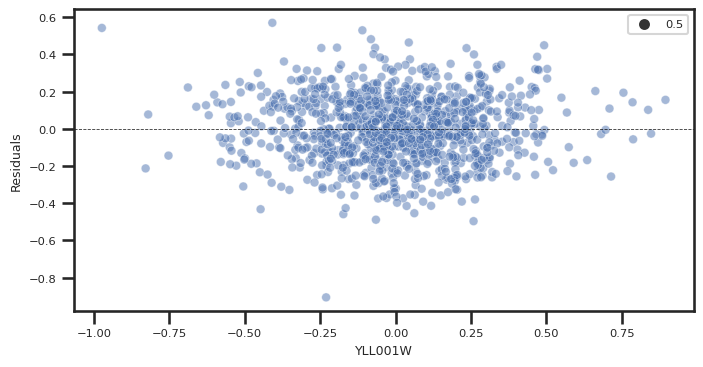

In [ ]:
#
# Plot residuals vs values of gene 1:
#
g = sns.scatterplot(x=yeast_exp[gene_1],y=regression_result.resid,
                size=0.5, alpha=0.5, palette="deep")

# draw a horizontal line at y = 0:
g.axhline(0, ls='--', c='black', alpha=0.8, lw=0.6)
g.set_ylabel('Residuals')

### What do you observe ?

In [ ]:
# You can write your answer in this cell


### In addition, the statsmodel package can also make other figures.
### You can *uncomment* the the code below if you want to try it.

In [ ]:
#import matplotlib as mpl

#nfig = 1
#with mpl.rc_context():
#    mpl.rc("figure", figsize=(nfig,nfig))
#    #fig = sm.graphics.plot_regress_exog(res, x_name)
#    fig = sm.graphics.plot_regress_exog(regression_result, gene_1)
#    fig.tight_layout(pad=1.0)

### Check the dependence on genotype
### a) Find the eQTL for the regulating gene:

In [ ]:
# Find the cis-EQTL for the regulating gene:
#regulator_gene = 'YLL001W'
regulator_gene = gene_1

gene_eqtl_table[gene_eqtl_table.gene== regulator_gene ]


,r_abs,gene,pmarker,r
1713,20462,YLL001W,chrXII:136527_T/C,0.15697


In [ ]:
regulator_eqtl = gene_eqtl_table[gene_eqtl_table.gene == regulator_gene ].pmarker.values[0]

In [ ]:
regulator_eqtl

'chrXII:136527_T/C'

In [ ]:
target_gene = gene_2
target_gene

'YDR477W'

### b) Collect the data into one dataframe: 
### Expression values of Regulator and Target, Residuals, eQTL Genotype

In [ ]:
#a_data = pan.DataFrame( {a_gene: a_exp})
collected_data = data_for_regression.copy()
#collect_a_data.columns = [a_name]

name_genotype = 'eQTL genotype'
collected_data[name_genotype] = genotypes[regulator_eqtl]

#a_name
#collect_a_data.columns

name_resids = 'Residuals'
collected_data[name_resids] = regression_result.resid

#collect_a_data[x_name] = yeast_exp[ x_name ]

### c) Make a figure of the Expression values of the regulating gene vs eQTL genotype

Text(0.5, 1.0, 'Figure of Regulator Expression')

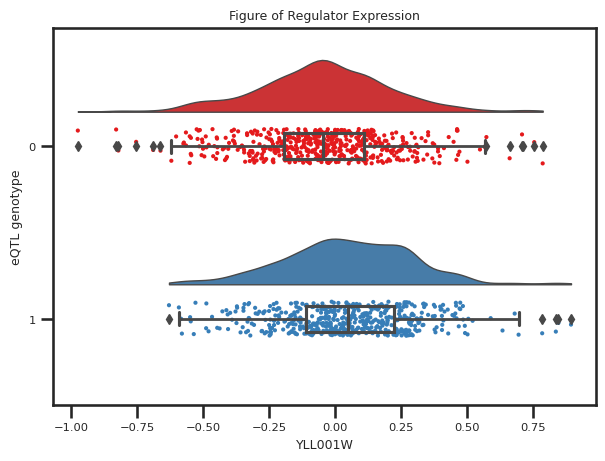

In [ ]:
#same thing with a single command: now x **must** be the categorical value
dx = "eQTL genotype"; dy = regulator_gene; ort = "h"; pal = "Set1"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

pt.RainCloud(x = dx, y = dy, data = collected_data, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

#plt.xlim((-2,2))
plt.title("Figure of Regulator Expression")

### d) Make a figure of the Expression values of the target gene vs eQTL genotype

Text(0.5, 1.0, 'Figure of Target Expression')

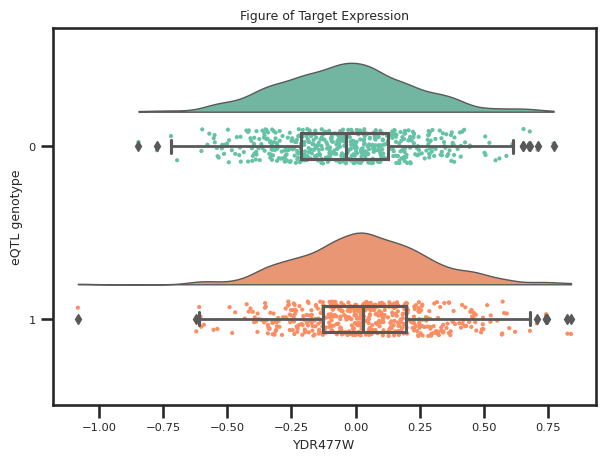

In [ ]:
dx = "eQTL genotype"; dy = target_gene; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

pt.RainCloud(x = dx, y = dy, data = collected_data, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

#plt.xlim((-2,2))
plt.title("Figure of Target Expression")

### e) Make a figure of the Residuals of the target gene vs eQTL genotype

Text(0.5, 1.0, 'Figure of residuals')

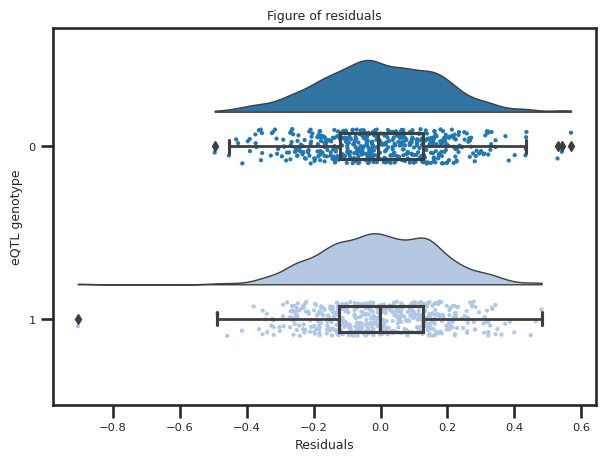

In [ ]:
dx = "eQTL genotype"; dy = "Residuals"; ort = "h"; pal = "tab20"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

pt.RainCloud(x = dx, y = dy, data = collected_data, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

#plt.xlim((-2,2))
plt.title("Figure of residuals")

### What do you observe ?

In [ ]:
# You can write your answer in this cell


## 3. Are the distributions for each genotype different ?

In [ ]:
genotypes_0 = collected_data[collected_data["eQTL genotype"]==0]
genotypes_1 = collected_data[collected_data["eQTL genotype"]==1]

In [ ]:
#from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu



In [ ]:
w, p = mannwhitneyu(genotypes_0[regulator_gene], genotypes_1[regulator_gene])
print('Test if the distributions of the Regulator are different for the two genotypes:')
print('p_value =', p)

Test if the distributions of the Regulator are different for the two genotypes:
p_value = 5.294418519384917e-10


In [ ]:
w, p = mannwhitneyu(genotypes_0[target_gene], genotypes_1[target_gene])
print('Test if the distributions of the Target are different for the two genotypes:')
print('p_value =', p)

Test if the distributions of the Target are different for the two genotypes:
p_value = 3.186806191781084e-06


In [ ]:
w, p = mannwhitneyu(genotypes_0["Residuals"], genotypes_1["Residuals"])
print('Test if the distributions of the Residuals are different for the two genotypes:')
print('p_value =', p)

Test if the distributions of the Residuals are different for the two genotypes:
p_value = 0.4419788818491733


### What do you observe ?

In [ ]:
# You can write your answer in this cell


## 2.b For STB5 and YHR163W

##### Write your code below

In [ ]:
# TODO: Write code here, based on the previous example.



### What do you observe ?

In [ ]:
# You can write your answer in this cell


# We can now check the results of the $P_2P_3$ test from Findr:
##  $P_2P_3$ sorted predictions for given genes are in the google drive folder:
>##   "Causal Inference/data/top_targets"
###  You can open the files in the google drive or load them here using the command gdown as we did with the other data above:
>###  !gdown https://drive.google.com/uc?id=SOME_FILE_ID
### where the SOME_FILE_ID can be found in the link on the google drive.
# .............................................................................
### The data corresponds to the analysis published in:
####     Ludl & Michoel (2021) Mol. Omics, 17, 241-251 
####     Comparison between instrumental variable and mediation-based methods for reconstructing causal gene networks in yeast
####	Publisher website: https://doi.org/10.1039/D0MO00140F
####	Preprint on arXiv: https://arxiv.org/abs/2010.07417


In [ ]:
# load data with gdown ...


In [ ]:
# define a gene name here
gene_name = ''

# use the top predictions from p2p3:
top_targets_file = 'sorted_'+gene_name+'_p2p3'
top_targets = pan.read_table(  top_targets_file,
                                names='target probability'.split(),
                                 header=0,
                                  delimiter=',')

In [ ]:
top_targets[top_targets.target == gene_2]

In [ ]:
# you can write more code here is you like


Load the uncorrected expression data and compare it to the corrected data:

In [ ]:
# The End.